# BOT DETECTION

## DATA PREPARATION

In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.ensemble import IsolationForest
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.svm import OneClassSVM
from kneed import KneeLocator
import re

In [80]:
# Function to clean text
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'[^A-Za-z0-9\\s]', '', text)
    return text

In [81]:
# Function to clean and split text into words
def clean_and_split(text):
    text = clean_text(text)
    words = set(text.split())
    return words

In [82]:
# Function to compute entropy, helps understand how "diverse" the values are
def compute_entropy(series):
    if series.empty:
        return 0
    
    counts = series.value_counts(normalize=True)
    
    entropy = 0
    for p in counts : 
        if p > 0 :
            entropy -= p*np.log2(p)
    
    return entropy

In [83]:
# Function to compute similarity between two sets
def text_similarity(t1, t2):
    intersection = len(t1.intersection(t2))
    
    union = len(t1.union(t2))
    
    if union == 0 : 
        return 0
    
    similarity = intersection / union
    return similarity

## FEATURES EXTRACTION

In [84]:
# To extract text features
def text_features(comments):
    features = {}

    # Average comment length
    comments_length = [len(c) for c in comments]
    features["avg_length"] = np.mean(comments_length)
    
    # Standard deviation
    if len(comments_length) > 1 : 
        features["std_length"] = np.std(comments_length)
    else : 
        features["std_length"] = 0
    
    # Number of comments that contains a URL
    features["url_count"] = sum("http" in c for c in comments)
    
    # Ratio of unique comments
    if comments : 
        features["keyword_repetition"] = len(set(comments)) / len(comments)  
    else : 
        features["keyword_repetition"] = 1

    # Ratio of unique words
    all_text = ' '.join(comments)
    words = all_text.split()
    total_words = len(words)
    unique_words = len(set(words))
    
    if total_words > 0 : 
        features['unique_words_ratio'] = unique_words / total_words  
    else : 
        features['unique_words_ratio'] = 0
    
    return features

In [85]:
# Extract temporal features
def time_features(time):
    features = {}

    if len(time) > 1:
        time_diffs = time.diff().dropna().dt.total_seconds() / 3600
        
        # Number of comments per hour
        if sum(time_diffs) > 0 : 
            features["comment_rate"] = len(time_diffs) / sum(time_diffs) 
        else : features["comment_rate"] = 0
        
        # Time variance
        features["time_variance"] = np.var(time_diffs)
        m = time_diffs.mean()
        s = time_diffs.std()
        
        if m > 0 :
            features["time_diffs"] = s / m 
        else : features["time_diffs"] = 0
        
        # Max number of comments posted in a 1 hour window
        comms_per_hour = [(time >= t) & (time < t + pd.Timedelta(hours=1)) for t in time]
        features["max_comms_per_hour"] = max(b.sum() for b in comms_per_hour)
    
    else: # If only one comment
        features["comment_rate"] = 0
        features["time_variance"] = 0
        features["time_diffs"] = 0
        features["max_comms_per_hour"] = 0

    # Most active hour 
    hours = time.dt.hour
    if not hours.empty : 
        features["most_freq_hour"] = hours.mode()[0] 
    else : features["most_freq_hour"] = -1
    features["hour_entropy"] = compute_entropy(hours)

    # Most active day
    days = time.dt.dayofweek
    if not days.empty : 
        features["most_freq_day"] = days.mode()[0] 
    else : features["most_freq_day"] = -1
    features["day_entropy"] = compute_entropy(days)

    # Highest proportion of comments posted in a hour
    if len(time) > 0 : 
        features["hourly_freq"] = hours.value_counts().max() / len(time)
    else : features["hourly_freq"] = 0
    
    return features


In [86]:
# Extract how users interact with threads
def thread_features(threads):
    features = {}

    features["unique_threads"] = threads.nunique()
    
    # Entropy of thread distribution
    thread_counts = threads.value_counts(normalize=True)
    
    for p in thread_counts : 
        if p > 0 : 
            features["thread_entropy"] = -sum(p * np.log(p) for p in thread_counts if p > 0)
    
    # Proportion of comments in the most replied-to thread
    if len(threads) > 1 :
        features["reply_freq"] = thread_counts.max() 
    else : features["reply_freq"] = 0
    
    return features

In [87]:
# Compute similarity between comments
def similarity_features(comments):
    features = {}

    if len(comments) > 1:
        tfidf = TfidfVectorizer()
        tfidf_matrix = tfidf.fit_transform(comments)
        sim_matrix = cosine_similarity(tfidf_matrix)
        sims = sim_matrix[np.triu_indices(len(comments), k=1)]
        features["similarity"] = np.mean(sims)
    else:
        features["similarity"] = 0

    return features

In [88]:
# Measure how similar comments are to the thread title
def context_similarity(group):
    similarities = []
    for _, row in group.iterrows():
        thread_words = clean_and_split(row["Main Thread"]) # words from thread title
        comment_words = clean_and_split(row["Content"]) # words from actual comment
        similarities.append(text_similarity(thread_words, comment_words))
    
    if similarities : 
        return {"avg_thread_similarity": np.mean(similarities)}
    else : 
        return 0

In [89]:
# Combine all feature extractions
def extract_features(group):
    comments = group["Content"].tolist()
    comment_times = group["Timestamp"].sort_values()
    threads = group["Main Thread"]
    
    features = {}
    features.update(text_features(comments))
    features.update(time_features(comment_times))
    features.update(thread_features(threads))
    features.update(similarity_features(comments))
    features.update(context_similarity(group))

    return features

## MODELIZATION

In [151]:
df = pd.read_excel('extra_reddit_comments_GTA6.xlsx')
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df['Content_raw'] = df['Content']  

df['Content'] = df['Content'].apply(clean_text)
df['Content'] = df['Content'].astype(str)
df['Main Thread'] = df['Main Thread'].astype(str)

In [152]:
df.drop(columns=["Sentiments (Excited/Disappointed/Angry/Sarcastic/Neutral)"], inplace=True)
df.head()

,User,Timestamp,Main Thread,Content,Content_raw
0,Dellrond,2025-04-10 22:47:12,I'm tired of waiting for Trailer 2 or more mar...,iworkatrockstarandthisposthasreallytouchedmeil...,I work at Rockstar and this post has really to...
1,Mister_Frowdo,2025-04-10 22:29:45,I'm tired of waiting for Trailer 2 or more mar...,ifeelyouimalsonotsurewhatrockstaristryingtodom...,I feel you. I'm also not sure what Rockstar is...
2,Capable_Region_1611,2025-04-10 22:28:15,I'm tired of waiting for Trailer 2 or more mar...,wedontevenhaveareleasedateffs,We dont even have a release date ffs
3,CoyoteOk3826,2025-04-10 22:26:37,I'm tired of waiting for Trailer 2 or more mar...,itllbesofunnyiftheyannounceagta5portthissubwil...,Itll be so funny if they announce a gta 5 port...
4,beezy604,2025-04-10 22:25:31,I'm tired of waiting for Trailer 2 or more mar...,andyouwillwaitevenlonger,And you will wait even longer


### 1. BOTS DETECTION BY USERS

In [153]:
user_groups = df.groupby('User')

# Extract features for each user
user_features = user_groups.apply(extract_features, include_groups=False)
feature_df = pd.DataFrame(user_features.tolist(), index=user_features.index)
feature_df = feature_df.fillna(0)

# Scale
scaler = StandardScaler()
scaled_features = scaler.fit_transform(feature_df)

In [154]:
# DBSCAN
knn = NearestNeighbors(n_neighbors=5)
knn.fit(scaled_features)

distances, _ = knn.kneighbors(scaled_features)

k_distances = distances[:, 4]  # distance to the 5th nearest neighbor

sorted_k_distances = np.sort(k_distances)

# Find the elbow point for epsilon
kl = KneeLocator(range(len(sorted_k_distances)), sorted_k_distances, curve='convex', direction='increasing')

if kl.elbow is not None : 
    epsilon = sorted_k_distances[kl.elbow]
else : 
    epsilon = 1.0
    
dbscan = DBSCAN(eps=epsilon, min_samples=5)
feature_df['is_bot_dbscan_u'] = dbscan.fit_predict(scaled_features)

In [155]:
# Isolation Forest
iso_forest = IsolationForest(contamination=0.1, random_state=42)
feature_df['is_bot_isof_u'] = iso_forest.fit_predict(scaled_features)

In [156]:
# One-Class SVM
ocsvm = OneClassSVM(nu=0.1)
feature_df['is_bot_osvm_u'] = ocsvm.fit_predict(scaled_features)

In [157]:
# Combine predictions using majority voting
iso_vote = (feature_df['is_bot_isof_u'] == -1).astype(int)
dbscan_vote = (feature_df['is_bot_dbscan_u'] == -1).astype(int)
svm_vote = (feature_df['is_bot_osvm_u'] == -1).astype(int)

feature_df['bot_score_u'] = iso_vote + dbscan_vote + svm_vote

feature_df['is_bot_u'] = (feature_df['bot_score_u'] >= 2).astype(int)

### 2. BOT DETECTION BY COMMENTARY

In [158]:
# Creation of the features by commentary
df['length'] = df['Content'].apply(len)
df['word_count'] = df['Content'].apply(lambda x: len(x.split()))
df['unique_word_ratio'] = df['Content'].apply(lambda x: len(set(x.split())) / len(x.split()) if len(x.split()) > 0 else 0)
df['has_url'] = df['Content'].str.contains('http').astype(int)
df['has_question'] = df['Content'].str.contains(r'\?').astype(int)
df['has_exclamation'] = df['Content'].str.contains('!').astype(int)
df['uppercase_ratio'] = df['Content_raw'].apply(lambda x: sum(1 for c in x if c.isupper()) / len(x) if len(x) > 0 else 0)
# df['punctuation_count'] = df['Content'].apply(lambda x: sum(1 for c in x if c in '.,!?'))
df['punctuation_count'] = df['Content_raw'].apply(lambda x: sum(1 for c in x if c in '.,!?'))

df['hour'] = df['Timestamp'].dt.hour
df['thread_similarity'] = df.apply(lambda row: text_similarity(clean_and_split(row["Main Thread"]), clean_and_split(row["Content"])), axis=1)


In [159]:
comment_features = df[[
    'length', 'word_count', 'unique_word_ratio', 'has_url', 'has_question', 'has_exclamation', 'uppercase_ratio',
    'punctuation_count', 'hour', 'thread_similarity'
]]

scaler_c = StandardScaler()
scaled_comment_features = scaler_c.fit_transform(comment_features)


In [160]:
# Isolation Forest
comment_model = IsolationForest(random_state=42)
comment_model.fit(comment_features)
df['is_bot_isof_c'] = (comment_model.predict(comment_features) == -1).astype(int)


In [161]:
# One Class svm
svm_model = OneClassSVM(nu=0.1) 
df['is_bot_osvm_c'] = (svm_model.fit_predict(scaled_comment_features) == -1).astype(int)

In [162]:
# DBSCAN
knn_c = NearestNeighbors(n_neighbors=5)
knn_c.fit(scaled_comment_features)
distances_c, _ = knn_c.kneighbors(scaled_comment_features)
sorted_d_c = np.sort(distances_c[:, 4])
kl_c = KneeLocator(range(len(sorted_d_c)), sorted_d_c, curve='convex', direction='increasing')
eps_c = sorted_d_c[kl_c.elbow] if kl_c.elbow is not None else 1.0

dbscan_c = DBSCAN(eps=eps_c, min_samples=5)
df['dbscan_cluster_comment'] = dbscan_c.fit_predict(scaled_comment_features)
df['is_bot_dbscan_c'] = (df['dbscan_cluster_comment'] == -1).astype(int)


In [163]:
# Fusion of the 3 models
df['bot_score_c'] = df[['is_bot_isof_c', 'is_bot_osvm_c', 'is_bot_dbscan_c']].sum(axis=1)

df['is_bot_c'] = (df['bot_score_c'] >= 2).astype(int)


In [164]:
df.head()

,User,Timestamp,Main Thread,Content,Content_raw,length,word_count,unique_word_ratio,has_url,has_question,...,uppercase_ratio,punctuation_count,hour,thread_similarity,is_bot_isof_c,is_bot_osvm_c,dbscan_cluster_comment,is_bot_dbscan_c,bot_score_c,is_bot_c
0,Dellrond,2025-04-10 22:47:12,I'm tired of waiting for Trailer 2 or more mar...,iworkatrockstarandthisposthasreallytouchedmeil...,I work at Rockstar and this post has really to...,60,1,1.0,0,0,...,0.051282,1,22,0.0,0,0,0,0,0,0
1,Mister_Frowdo,2025-04-10 22:29:45,I'm tired of waiting for Trailer 2 or more mar...,ifeelyouimalsonotsurewhatrockstaristryingtodom...,I feel you. I'm also not sure what Rockstar is...,381,1,1.0,0,0,...,0.018595,9,22,0.0,1,1,0,0,2,1
2,Capable_Region_1611,2025-04-10 22:28:15,I'm tired of waiting for Trailer 2 or more mar...,wedontevenhaveareleasedateffs,We dont even have a release date ffs,29,1,1.0,0,0,...,0.027778,0,22,0.0,0,0,0,0,0,0
3,CoyoteOk3826,2025-04-10 22:26:37,I'm tired of waiting for Trailer 2 or more mar...,itllbesofunnyiftheyannounceagta5portthissubwil...,Itll be so funny if they announce a gta 5 port...,63,1,1.0,0,0,...,0.024390,2,22,0.0,0,0,0,0,0,0
4,beezy604,2025-04-10 22:25:31,I'm tired of waiting for Trailer 2 or more mar...,andyouwillwaitevenlonger,And you will wait even longer,24,1,1.0,0,0,...,0.034483,0,22,0.0,0,0,0,0,0,0


In [165]:
print(df.columns.tolist())


['User', 'Timestamp', 'Main Thread', 'Content', 'Content_raw', 'length', 'word_count', 'unique_word_ratio', 'has_url', 'has_question', 'has_exclamation', 'uppercase_ratio', 'punctuation_count', 'hour', 'thread_similarity', 'is_bot_isof_c', 'is_bot_osvm_c', 'dbscan_cluster_comment', 'is_bot_dbscan_c', 'bot_score_c', 'is_bot_c']


### 3. FUSION OF THE TWO TYPES OF DETECTION

In [166]:
# Fusion of users predictions
df = df.merge(feature_df[['is_bot_isof_u','is_bot_osvm_u','is_bot_dbscan_u','bot_score_u','is_bot_u']], left_on='User', right_index=True, how='left')

# Final fusion, if one of the two models detect a bot, it is a bot
df['is_bot'] = ((df['is_bot_u'] == 1) | (df['is_bot_c'] == 1)).astype(int)


df.to_excel('is_bot.xlsx', index=False)

print("Bot detection completed. Results saved to 'is_bot.xlsx'.")

Bot detection completed. Results saved to 'is_bot.xlsx'.


In [167]:
df.head()

,User,Timestamp,Main Thread,Content,Content_raw,length,word_count,unique_word_ratio,has_url,has_question,...,dbscan_cluster_comment,is_bot_dbscan_c,bot_score_c,is_bot_c,is_bot_isof_u,is_bot_osvm_u,is_bot_dbscan_u,bot_score_u,is_bot_u,is_bot
0,Dellrond,2025-04-10 22:47:12,I'm tired of waiting for Trailer 2 or more mar...,iworkatrockstarandthisposthasreallytouchedmeil...,I work at Rockstar and this post has really to...,60,1,1.0,0,0,...,0,0,0,0,1,1,0,0,0,0
1,Mister_Frowdo,2025-04-10 22:29:45,I'm tired of waiting for Trailer 2 or more mar...,ifeelyouimalsonotsurewhatrockstaristryingtodom...,I feel you. I'm also not sure what Rockstar is...,381,1,1.0,0,0,...,0,0,2,1,1,1,0,0,0,1
2,Capable_Region_1611,2025-04-10 22:28:15,I'm tired of waiting for Trailer 2 or more mar...,wedontevenhaveareleasedateffs,We dont even have a release date ffs,29,1,1.0,0,0,...,0,0,0,0,1,1,0,0,0,0
3,CoyoteOk3826,2025-04-10 22:26:37,I'm tired of waiting for Trailer 2 or more mar...,itllbesofunnyiftheyannounceagta5portthissubwil...,Itll be so funny if they announce a gta 5 port...,63,1,1.0,0,0,...,0,0,0,0,1,1,0,0,0,0
4,beezy604,2025-04-10 22:25:31,I'm tired of waiting for Trailer 2 or more mar...,andyouwillwaitevenlonger,And you will wait even longer,24,1,1.0,0,0,...,0,0,0,0,1,1,0,0,0,0


# RESULTS ANALYSIS

### 1. BOTS DETECTION BY USERS

In [168]:
n_bots = feature_df['is_bot_u'].sum()
n_total = feature_df.shape[0]
print(f"{n_bots} bots detected out of {n_total} users ({100 * n_bots / n_total:.1f}%)")


120 bots detected out of 1575 users (7.6%)


Text(0, 0.5, 'Frequency')

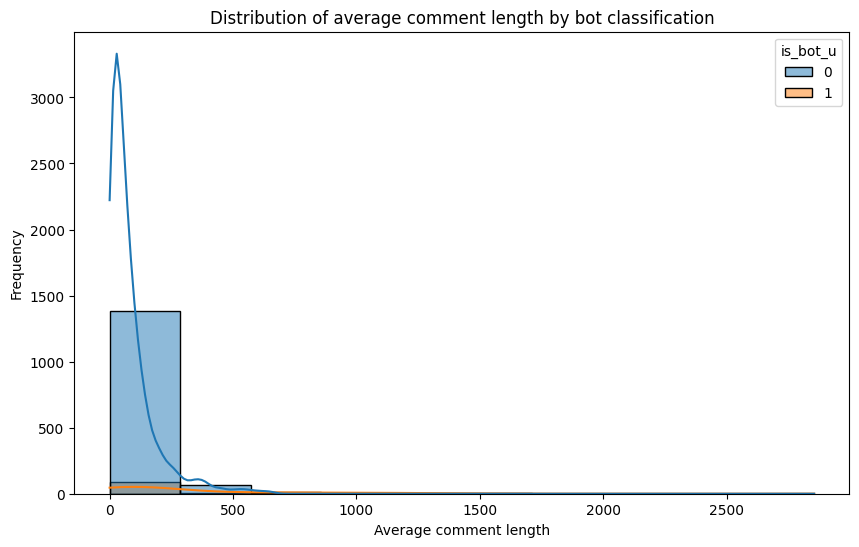

In [169]:
# Distribution of average comment length by bot classification
df['comment_length'] = df['Content'].str.len()
user_avg_length = df.groupby('User').agg({'comment_length': 'mean', 'is_bot_u': 'first'}).reset_index()

plt.figure(figsize=(10, 6))
sns.histplot(data=user_avg_length, x='comment_length', hue='is_bot_u', kde=True, bins=10)
plt.title('Distribution of average comment length by bot classification')
plt.xlabel('Average comment length')
plt.ylabel('Frequency')

In [170]:
# Compute comments length
df['comment_length'] = df['Content'].str.len()
user_avg_length = df.groupby('User').agg({
    'comment_length': 'mean',
    'is_bot_u': 'first'  
}).reset_index()

# Mean
bot_mean = user_avg_length[user_avg_length['is_bot_u'] == 1]['comment_length'].mean()
human_mean = user_avg_length[user_avg_length['is_bot_u'] == 0]['comment_length'].mean()

print(f"Average comment length (bots): {bot_mean:.2f}")
print(f"Average comment length (humans): {human_mean:.2f}")


Average comment length (bots): 332.98
Average comment length (humans): 83.34


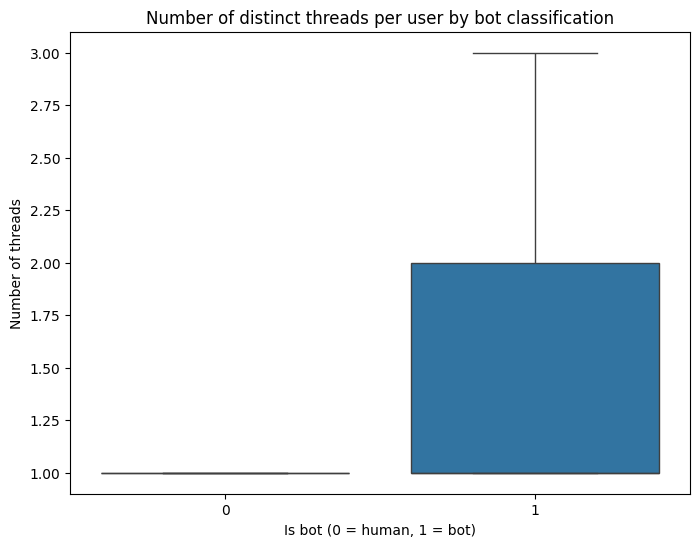

In [171]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=feature_df, x='is_bot_u', y='unique_threads')
plt.title('Number of distinct threads per user by bot classification')
plt.xlabel('Is bot (0 = human, 1 = bot)')
plt.ylabel('Number of threads')
plt.show()


C:\Users\phouv\AppData\Local\Temp\ipykernel_34828\3015067189.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Is Bot (User Level)')


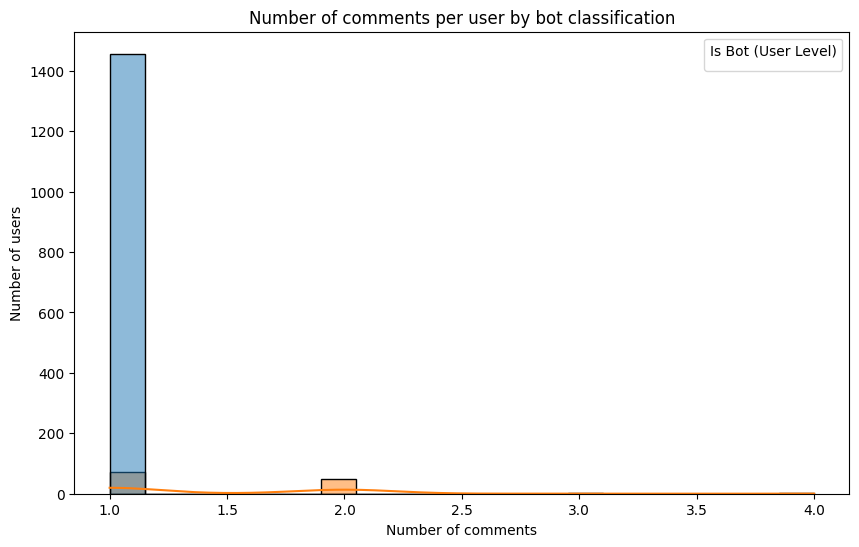

In [137]:
# Number of comments per user
user_comment_counts = df.groupby('User').size().reset_index(name='num_comments')

# Add user-level bot classification from feature_df
user_comment_counts = user_comment_counts.merge(
    feature_df[['is_bot_u']], left_on='User', right_index=True, how='left'
)

# Visualization
plt.figure(figsize=(10, 6))
sns.histplot(data=user_comment_counts, x='num_comments', hue='is_bot_u', bins=20, kde=True)
plt.title('Number of comments per user by bot classification')
plt.xlabel('Number of comments')
plt.ylabel('Number of users')
plt.legend(title='Is Bot (User Level)')
plt.show()


### 2. BOTS DETECTION BY COMMENTS

In [172]:
n_c_bots = df['is_bot_c'].sum()
n_total_comments = df.shape[0]
print(f"{n_c_bots} comment-level bots detected out of {n_total_comments} comments ({100 * n_c_bots / n_total_comments:.1f}%)")


123 comment-level bots detected out of 1631 comments (7.5%)


Text(0, 0.5, 'Frequency')

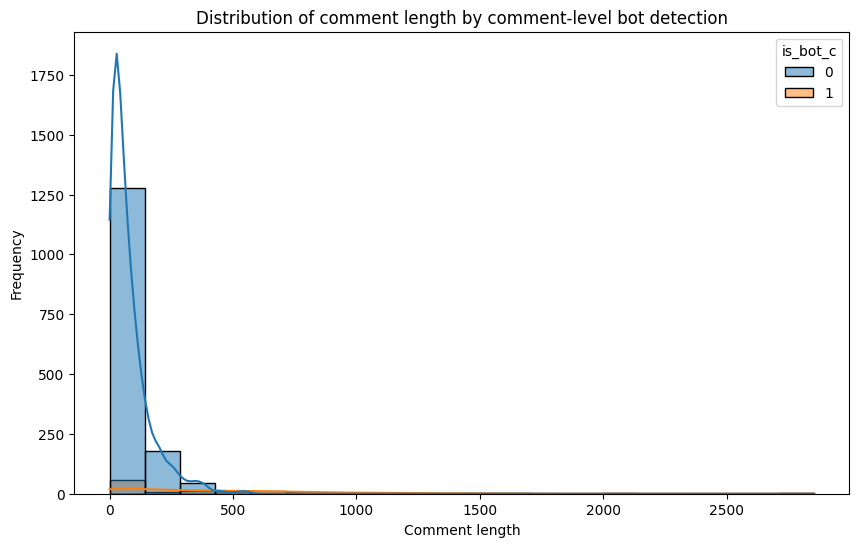

In [173]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='length', hue='is_bot_c', kde=True, bins=20)
plt.title('Distribution of comment length by comment-level bot detection')
plt.xlabel('Comment length')
plt.ylabel('Frequency')


In [174]:
length_stats = df.groupby('is_bot_c')['length'].describe()
print("Comment length statistics:\n", length_stats)



Comment length statistics:
            count        mean         std  min   25%    50%    75%     max
is_bot_c                                                                 
0         1508.0   78.789788   83.023035  2.0  23.0   52.0  104.0   567.0
1          123.0  397.382114  473.199911  0.0  25.5  285.0  587.0  2854.0


Text(0, 0.5, 'Number of comments')

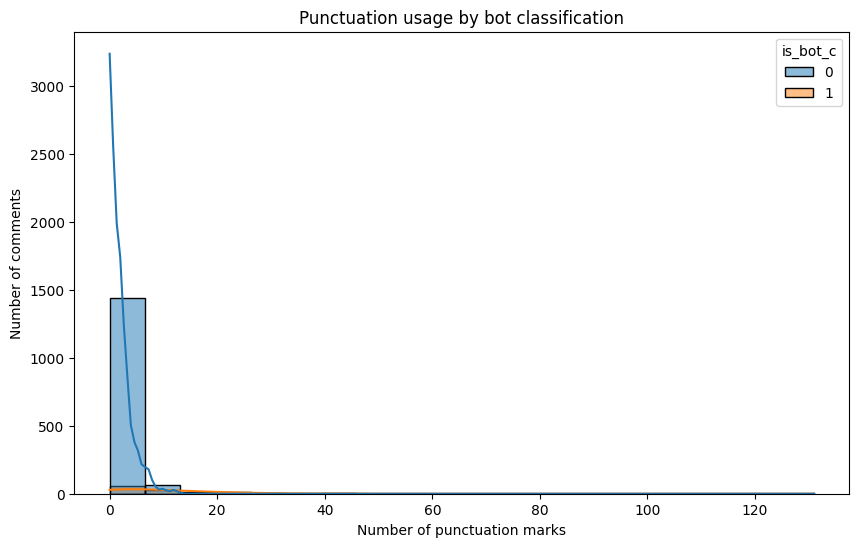

In [175]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='punctuation_count', hue='is_bot_c', bins=20, kde=True)
plt.title('Punctuation usage by bot classification')
plt.xlabel('Number of punctuation marks')
plt.ylabel('Number of comments')


Text(0, 0.5, 'Share of comments with URL')

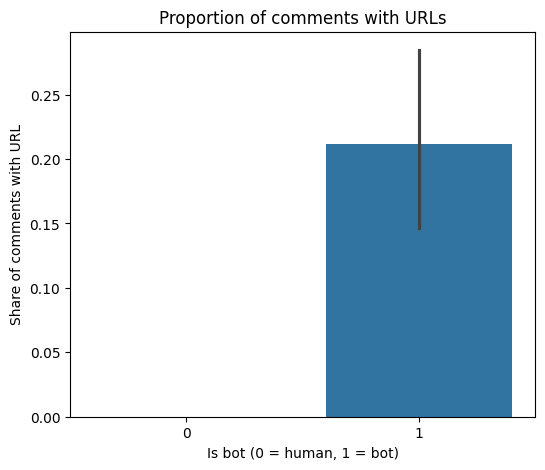

In [176]:
plt.figure(figsize=(6, 5))
sns.barplot(data=df, x='is_bot_c', y='has_url')
plt.title('Proportion of comments with URLs')
plt.xlabel('Is bot (0 = human, 1 = bot)')
plt.ylabel('Share of comments with URL')


In [177]:
url_proportion = df.groupby('is_bot_c')['has_url'].mean()
print("\nProportion of comments with URLs:\n", url_proportion)


Proportion of comments with URLs:
 is_bot_c
0    0.000000
1    0.211382
Name: has_url, dtype: float64


Text(0, 0.5, 'Uppercase letter ratio')

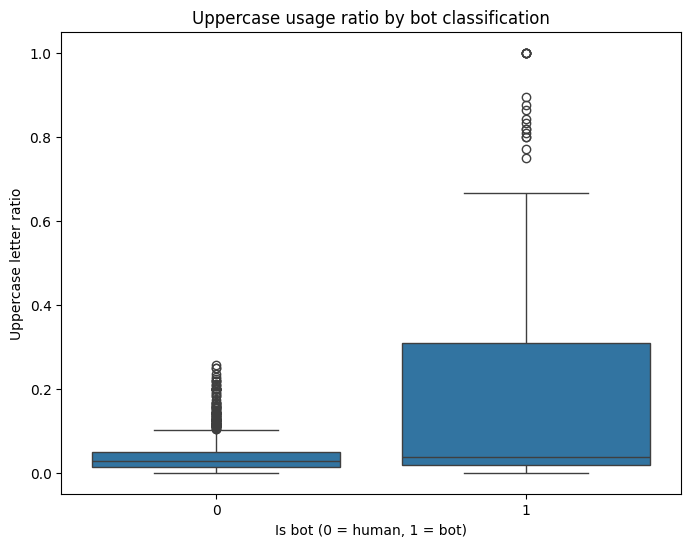

In [178]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x='is_bot_c', y='uppercase_ratio')
plt.title('Uppercase usage ratio by bot classification')
plt.xlabel('Is bot (0 = human, 1 = bot)')
plt.ylabel('Uppercase letter ratio')


### 3. ANALYSES ON FINAL IS_BOT

In [179]:
n_final_bots = df['is_bot'].sum()
n_total_comments = df.shape[0]
print(f"{n_final_bots} bots detected out of {n_total_comments} total comments ({100 * n_final_bots / n_total_comments:.1f}%)")


242 bots detected out of 1631 total comments (14.8%)


Average comment length (final classification):
is_bot
0     78.016559
1    245.157025
Name: length, dtype: float64


Text(0.5, 1.0, 'Comment length by final bot classification')

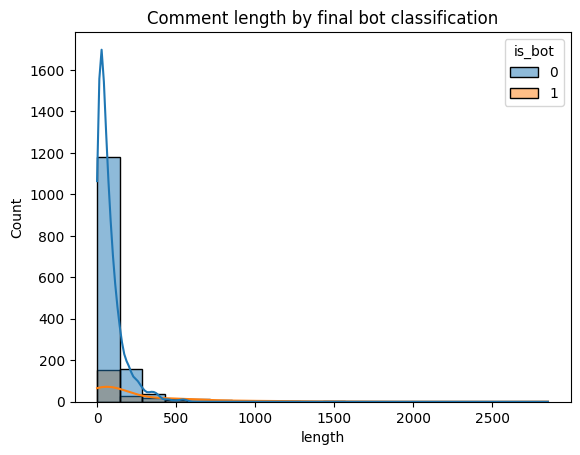

In [180]:
print("Average comment length (final classification):")
print(df.groupby('is_bot')['length'].mean())

sns.histplot(data=df, x='length', hue='is_bot', kde=True, bins=20)
plt.title("Comment length by final bot classification")


Text(50.722222222222214, 0.5, 'User-level')

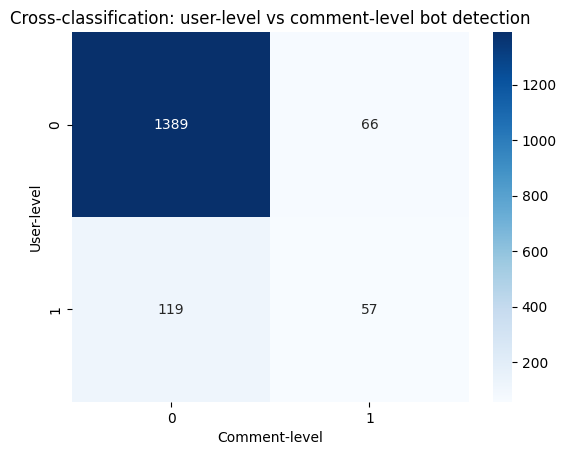

In [181]:
cross = pd.crosstab(df['is_bot_u'], df['is_bot_c'])
sns.heatmap(cross, annot=True, fmt='d', cmap='Blues')
plt.title('Cross-classification: user-level vs comment-level bot detection')
plt.xlabel('Comment-level')
plt.ylabel('User-level')

Text(0, 0.5, 'Number of comments flagged')

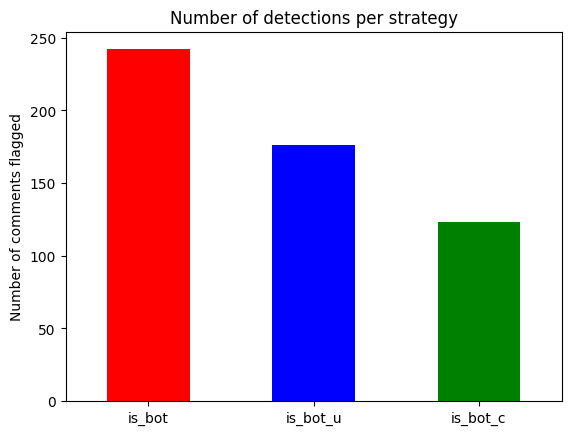

In [182]:
fusion_counts = df[['is_bot', 'is_bot_u', 'is_bot_c']].sum()
fusion_counts.plot(kind='bar', color=['red', 'blue', 'green'])
plt.title('Number of detections per strategy')
plt.xticks(rotation=0)
plt.ylabel('Number of comments flagged')


Text(0, 0.5, 'Number of users')

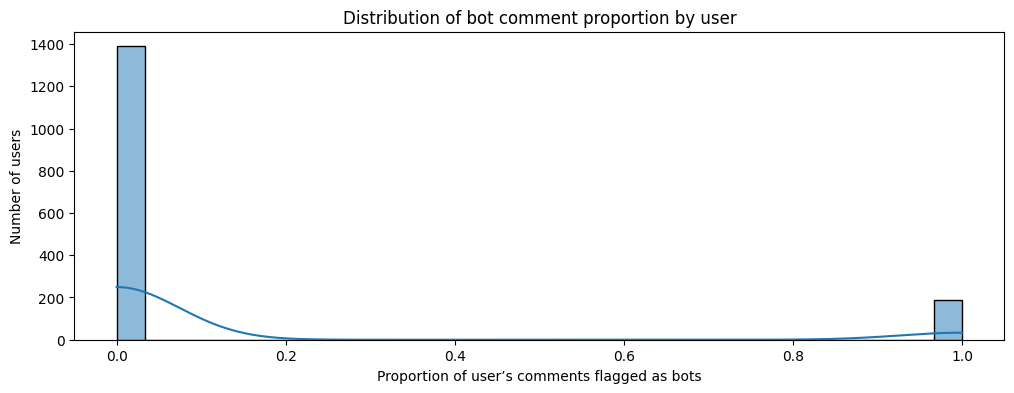

In [183]:
user_bot_ratio = df.groupby('User')['is_bot'].mean().sort_values(ascending=False)

plt.figure(figsize=(12, 4))
sns.histplot(user_bot_ratio, bins=30, kde=True)
plt.title('Distribution of bot comment proportion by user')
plt.xlabel('Proportion of user’s comments flagged as bots')
plt.ylabel('Number of users')


In [184]:
# Case where user or commentary is classed bot but not the other one
disagreements = df[(df['is_bot_u'] != df['is_bot_c'])]
print(disagreements[['User', 'is_bot_u', 'is_bot_c', 'Content']].head())


                   User  is_bot_u  is_bot_c  \
1         Mister_Frowdo         0         1   
10          Sir_Jerkums         1         0   
15  YogurtclosetIcy4328         1         0   
17          imperiex_26         1         0   
26         dylan_021800         1         0   

                                              Content  
1   ifeelyouimalsonotsurewhatrockstaristryingtodom...  
10  icompletelygaveupandamjustgonnabesurprisedwhen...  
15  theyhavegottenveryarrogantihopeandpraythatthen...  
17  makeyourselfbusywithsomethinginlifeandmutethis...  
26  yeahifeelyouidefinitelythinkthatwhenthetrailer...  


Text(0, 0.5, 'Average bot score per comment (0–1)')

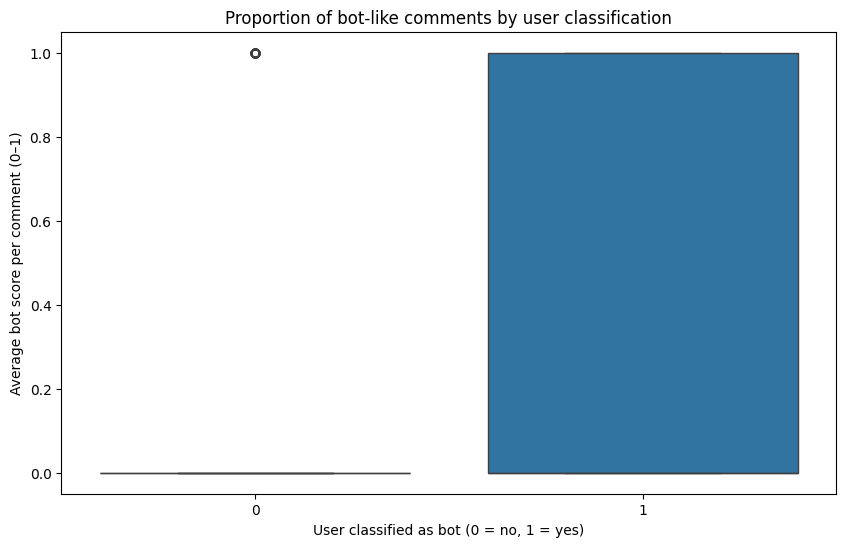

In [185]:
# % of commentaries classed as bot by the commentary model
comment_bot_rate = df.groupby('User')['is_bot_c'].mean().reset_index(name='comment_bot_rate')

comment_bot_rate = comment_bot_rate.merge(feature_df[['is_bot_u']], left_on='User', right_index=True)

plt.figure(figsize=(10,6))
sns.boxplot(data=comment_bot_rate, x='is_bot_u', y='comment_bot_rate')
plt.title('Proportion of bot-like comments by user classification')
plt.xlabel('User classified as bot (0 = no, 1 = yes)')
plt.ylabel('Average bot score per comment (0–1)')


C:\Users\phouv\AppData\Local\Temp\ipykernel_34828\1842159835.py:15: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot = pd.pivot_table(df_user_commentbot,


Text(50.722222222222214, 0.5, 'User activity level (comments)')

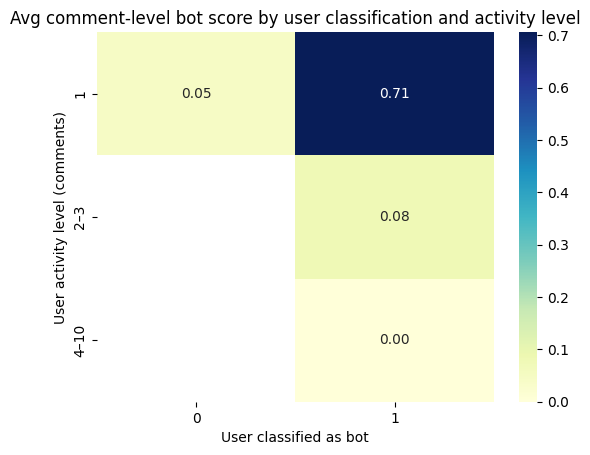

In [187]:
# Number of commentaries by user
df['nb_comments_user'] = df.groupby('User')['Content'].transform('count')
df_user_commentbot = df.groupby('User').agg({
    'is_bot_u': 'first',
    'is_bot_c': 'mean',
    'nb_comments_user': 'first'
}).reset_index()

# Categorize the number of commentaries
df_user_commentbot['activity_level'] = pd.cut(df_user_commentbot['nb_comments_user'],
                                              bins=[0, 1, 3, 10, 50],
                                              labels=['1', '2–3', '4–10', '11+'])

# Heatmap
pivot = pd.pivot_table(df_user_commentbot,
                       values='is_bot_c',
                       index='activity_level',
                       columns='is_bot_u',
                       aggfunc='mean')

sns.heatmap(pivot, annot=True, cmap='YlGnBu', fmt='.2f')
plt.title("Avg comment-level bot score by user classification and activity level")
plt.xlabel("User classified as bot")
plt.ylabel("User activity level (comments)")


# 5 GENERATED AI COMMENTS TO SEE IF OUR WORK CLASS THEM AS BOTS

In [126]:
import datetime
import random

fake_bot_data = pd.DataFrame({
    "User": [f"FakeBot_{i}" for i in range(1, 6)],
    "Timestamp": [datetime.datetime(2025, 1, 1, 12, 0) + datetime.timedelta(minutes=i*10) for i in range(5)],
    "Main Thread": ["Official GTA6 Trailer Discussion"] * 5,
    "Content": [
        "PRE-ORDER GTA6 NOW! Limited-time offer: gta6promo.xyz",
        "Earn free Shark Cards by visiting gta6goldgenerator.net",
        "GTA6 is going to break the internet!!! BEST GAME EVER!!!",
        "Click here to unlock secret beta access : gta6unlocker.org",
        "This trailer sucks. Rockstar should quit. GTA5 was better."
    ],
    
})

fake_bot_data["is_fake_bot"] = 1

fake_bot_data

,User,Timestamp,Main Thread,Content,is_fake_bot
0,FakeBot_1,2025-01-01 12:00:00,Official GTA6 Trailer Discussion,PRE-ORDER GTA6 NOW! Limited-time offer: gta6pr...,1
1,FakeBot_2,2025-01-01 12:10:00,Official GTA6 Trailer Discussion,Earn free Shark Cards by visiting gta6goldgene...,1
2,FakeBot_3,2025-01-01 12:20:00,Official GTA6 Trailer Discussion,GTA6 is going to break the internet!!! BEST GA...,1
3,FakeBot_4,2025-01-01 12:30:00,Official GTA6 Trailer Discussion,Click here to unlock secret beta access : gta6...,1
4,FakeBot_5,2025-01-01 12:40:00,Official GTA6 Trailer Discussion,This trailer sucks. Rockstar should quit. GTA5...,1


In [127]:
df = pd.read_excel('extra_reddit_comments_GTA6.xlsx')
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df['Content'] = df['Content'].apply(clean_text)
df['Content'] = df['Content'].astype(str)
df['Main Thread'] = df['Main Thread'].astype(str)

In [128]:
df['is_fake_bot'] = 0

df = pd.concat([df, fake_bot_data], ignore_index=True)

In [129]:
df

,User,Timestamp,Main Thread,Content,Sentiments (Excited/Disappointed/Angry/Sarcastic/Neutral),is_fake_bot
0,Dellrond,2025-04-10 22:47:12,I'm tired of waiting for Trailer 2 or more mar...,iworkatrockstarandthisposthasreallytouchedmeil...,NaN,0
1,Mister_Frowdo,2025-04-10 22:29:45,I'm tired of waiting for Trailer 2 or more mar...,ifeelyouimalsonotsurewhatrockstaristryingtodom...,NaN,0
2,Capable_Region_1611,2025-04-10 22:28:15,I'm tired of waiting for Trailer 2 or more mar...,wedontevenhaveareleasedateffs,NaN,0
3,CoyoteOk3826,2025-04-10 22:26:37,I'm tired of waiting for Trailer 2 or more mar...,itllbesofunnyiftheyannounceagta5portthissubwil...,NaN,0
4,beezy604,2025-04-10 22:25:31,I'm tired of waiting for Trailer 2 or more mar...,andyouwillwaitevenlonger,NaN,0
...,...,...,...,...,...,...
1631,FakeBot_1,2025-01-01 12:00:00,Official GTA6 Trailer Discussion,PRE-ORDER GTA6 NOW! Limited-time offer: gta6pr...,NaN,1
1632,FakeBot_2,2025-01-01 12:10:00,Official GTA6 Trailer Discussion,Earn free Shark Cards by visiting gta6goldgene...,NaN,1
1633,FakeBot_3,2025-01-01 12:20:00,Official GTA6 Trailer Discussion,GTA6 is going to break the internet!!! BEST GA...,NaN,1
1634,FakeBot_4,2025-01-01 12:30:00,Official GTA6 Trailer Discussion,Click here to unlock secret beta access : gta6...,NaN,1


In [130]:
user_groups = df.groupby('User')

# Extract features for each user
user_features = user_groups.apply(extract_features, include_groups=False)
feature_df = pd.DataFrame(user_features.tolist(), index=user_features.index)
feature_df = feature_df.fillna(0)

# Scale
scaler = StandardScaler()
scaled_features = scaler.fit_transform(feature_df)

In [131]:
################################ USER ######################################

# DBSCAN --------------------------------------------------------
knn = NearestNeighbors(n_neighbors=5)
knn.fit(scaled_features)

distances, _ = knn.kneighbors(scaled_features)

k_distances = distances[:, 4]  # distance to the 5th nearest neighbor

sorted_k_distances = np.sort(k_distances)

# Find the elbow point for epsilon
kl = KneeLocator(range(len(sorted_k_distances)), sorted_k_distances, curve='convex', direction='increasing')

if kl.elbow is not None : 
    epsilon = sorted_k_distances[kl.elbow]
else : 
    epsilon = 1.0
    
dbscan = DBSCAN(eps=epsilon, min_samples=5)
feature_df['is_bot_dbscan_u'] = dbscan.fit_predict(scaled_features)



# Isolation Forest ---------------------------------------------------
iso_forest = IsolationForest(contamination=0.1, random_state=42)
feature_df['is_bot_isof_u'] = iso_forest.fit_predict(scaled_features)

# One-Class SVM ----------------------------------------------------------
ocsvm = OneClassSVM(nu=0.1)
feature_df['is_bot_osvm_u'] = ocsvm.fit_predict(scaled_features)

# Combine predictions using majority voting ---------------------------------
iso_vote = (feature_df['is_bot_isof_u'] == -1).astype(int)
dbscan_vote = (feature_df['is_bot_dbscan_u'] == -1).astype(int)
svm_vote = (feature_df['is_bot_osvm_u'] == -1).astype(int)

feature_df['bot_score_u'] = iso_vote + dbscan_vote + svm_vote

feature_df['is_bot_u'] = (feature_df['bot_score_u'] >= 2).astype(int)

In [132]:
################################ COMMENTARY ######################################

# Creation of the features by commentary
df['length'] = df['Content'].apply(len)
df['word_count'] = df['Content'].apply(lambda x: len(x.split()))
df['unique_word_ratio'] = df['Content'].apply(lambda x: len(set(x.split())) / len(x.split()) if len(x.split()) > 0 else 0)
df['has_url'] = df['Content'].str.contains('http').astype(int)
df['has_question'] = df['Content'].str.contains(r'\?').astype(int)
df['has_exclamation'] = df['Content'].str.contains('!').astype(int)
df['uppercase_ratio'] = df['Content'].apply(lambda x: sum(1 for c in x if c.isupper()) / len(x) if len(x) > 0 else 0)
df['punctuation_count'] = df['Content'].apply(lambda x: sum(1 for c in x if c in '.,!?'))
df['hour'] = df['Timestamp'].dt.hour
df['thread_similarity'] = df.apply(lambda row: text_similarity(clean_and_split(row["Main Thread"]), clean_and_split(row["Content"])), axis=1)


In [133]:
comment_features = df[[
    'length', 'word_count', 'unique_word_ratio', 'has_url', 'has_question', 'has_exclamation', 'uppercase_ratio',
    'punctuation_count', 'hour', 'thread_similarity'
]]

scaler_c = StandardScaler()
scaled_comment_features = scaler_c.fit_transform(comment_features)


In [134]:
# Isolation Forest ------------------------------------------------
comment_model = IsolationForest(random_state=42)
comment_model.fit(comment_features)
df['is_bot_isof_c'] = (comment_model.predict(comment_features) == -1).astype(int)


# One Class  ----------------------------------------------------------
svm_model = OneClassSVM(nu=0.1) 
df['is_bot_osvm_c'] = (svm_model.fit_predict(scaled_comment_features) == -1).astype(int)


# DBSCAN --------------------------------------------------------------
knn_c = NearestNeighbors(n_neighbors=5)
knn_c.fit(scaled_comment_features)
distances_c, _ = knn_c.kneighbors(scaled_comment_features)
sorted_d_c = np.sort(distances_c[:, 4])
kl_c = KneeLocator(range(len(sorted_d_c)), sorted_d_c, curve='convex', direction='increasing')
eps_c = sorted_d_c[kl_c.elbow] if kl_c.elbow is not None else 1.0

dbscan_c = DBSCAN(eps=eps_c, min_samples=5)
df['dbscan_cluster_comment'] = dbscan_c.fit_predict(scaled_comment_features)
df['is_bot_dbscan_c'] = (df['dbscan_cluster_comment'] == -1).astype(int)

# Fusion of the 3 models -----------------------------------------------------
df['bot_score_c'] = df[['is_bot_isof_c', 'is_bot_osvm_c', 'is_bot_dbscan_c']].sum(axis=1)

df['is_bot_c'] = (df['bot_score_c'] >= 2).astype(int)

In [135]:
# Fusion of users predictions
df = df.merge(feature_df[['is_bot_isof_u','is_bot_osvm_u','is_bot_dbscan_u','bot_score_u','is_bot_u']], left_on='User', right_index=True, how='left')

# Final fusion, if one of the two models detect a bot, it is a bot
df['is_bot'] = ((df['is_bot_u'] == 1) | (df['is_bot_c'] == 1)).astype(int)


df.to_excel('is_bot_with_ai_generated_bots.xlsx', index=False)

print("Bot detection completed. Results saved to 'is_bot_with_ai_generated_bots.xlsx'.")

Bot detection completed. Results saved to 'is_bot_with_ai_generated_bots.xlsx'.


In [190]:
df_ai = pd.read_excel("is_bot_with_ai_generated_bots.xlsx")

print(df_ai[['User','is_bot']].tail(5))

           User  is_bot
1631  FakeBot_1       1
1632  FakeBot_2       1
1633  FakeBot_3       1
1634  FakeBot_4       1
1635  FakeBot_5       1
